In [1]:
# import nibabel as nib
# from nipype.interfaces import fsl
# from scipy.optimize import curve_fit
# from scipy import stats
# import numpy as np
# import pandas as pd
# import os
# from shutil import copyfile
# import matplotlib.pyplot as plt
# from collections import OrderedDict

from nipype.interfaces import fsl
import nibabel as nib
import os

from nipype.interfaces import fsl
from nipype.interfaces import freesurfer
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.algorithms.modelgen as model
from nipype.interfaces.utility import Merge

from IPython.display import Image

from config import root

# Prepare

In [2]:
# sessions per subject.
subjects = [1,2,3,4,5,6]
sessions = {1: [2,3,4,5],
            2: [2,3],
            3: [1,2,3,4],
            4: [1,2,3],
            5: [1,2,4,5],
            6: [1,2]}

In [3]:
base_dir = os.path.join(root, "data")
data_dir = os.path.join(root, "data", "in_analysis")
working_dir = os.path.join(root, "data", "working_dir")
mni_standard_path = os.path.join(root, "data", "in_analysis", "nii", "standard", "MNI152_T1_2mm.nii.gz")
mni_standard_brain_path = os.path.join(root, "data", "in_analysis", "nii", "standard", "MNI152_T1_2mm_brain.nii.gz")
fs_dir = os.path.join(root, "data", "in_analysis", "fs_subjects")

In [4]:
# nii.gz
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

# Preprocessing

In [5]:
def select_last_in_list(files, if_containing="pve"):
    """Return the last pve file in sorted list."""
    if_containing = "pve"
    return sorted([f for f in files if if_containing in f])[-1]

## Search functionals
To iterate over subjects and sessions, here we create three input nodes for observers with two, three or four sessions. The pipeline should run three times with any of these three input nodes (by commenting out the others). There might be a better wat to do this, but it works.

### Subjects with two sessions

In [6]:
two_ses = pe.Node(
    util.IdentityInterface(
        fields=["sub_id", "ses_id"]),
    name='two_ses')

# Subjects with two sessions
two_ses.iterables = [
    ("sub_id", ["sub_%03d" % i for i in [2, 6]]),
    ("ses_id", ["ses_%03d" % i for i in range(2)])
]

### Subjects with three sessions

In [7]:
three_ses = pe.Node(
    util.IdentityInterface(
        fields=["sub_id", "ses_id"]),
    name='three_ses')

# Subjects with three sessions
three_ses.iterables = [
    ("sub_id", ["sub_%03d" % i for i in [4]]),
    ("ses_id", ["ses_%03d" % i for i in range(3)])
]

### Subjects with four sessions

In [8]:
four_ses = pe.Node(
    util.IdentityInterface(
        fields=["sub_id", "ses_id"]),
    name='four_ses')

# Subjects with four sessions
four_ses.iterables = [
    ("sub_id", ["sub_%03d" % i for i in [1, 3, 5]]),
    ("ses_id", ["ses_%03d" % i for i in range(4)])
]

### Input nodes

In [9]:
# File templates for different subjects and sessions
templates = dict(
    search_func='nii/{sub_id}/{ses_id}/functional/run_*.nii.gz',
    inplane='nii/{sub_id}/{ses_id}/anatomy/inplane.nii.gz',
    inplane1='nii/{sub_id}/ses_000/anatomy/inplane.nii.gz',
    fs_orig='fs_subjects/{sub_id}/mri/orig.nii.gz',
    fs_brain='fs_subjects/{sub_id}/mri/brain.nii.gz',
)

# SelectFiles Node to handle 
# session specific file templates
files = pe.Node(
    SelectFiles(
        templates, 
        base_directory=data_dir, 
        sort_filelist=True),
    name='files')

### Create the pipeline
#### Create nodes

We are copying fsl's epireg here.

In [10]:
# Slice time correction
slicetimer = pe.MapNode(
    interface=fsl.SliceTimer(
        interleaved=True, 
        time_repetition=2.1),
    iterfield=["in_file"],
    name='slicetimer'
)

# Motion Correction
motion_correct = pe.MapNode(
    interface=fsl.MCFLIRT(
        cost='normmi',
        stages=4,
        interpolation='sinc',
        save_mats=True,
        save_plots=True,
        save_rms=True),
    iterfield=["in_file"],
    name='motion_correct'
)

bet = pe.Node(fsl.BET(frac=.15), name="bet")

# Segment gray/white matter
fast = pe.Node(fsl.FAST(out_basename='inplane_fast'), name='fast')

# Apply binary threshold
threshold = pe.Node(fsl.maths.Threshold(thresh=.5, args='-bin'), name='threshold')

# Prealignment
prealign = pe.MapNode(
    interface=fsl.FLIRT(dof=6), 
    iterfield=["in_file"],
    name='prealign')

# Use boundary based registration
bbr = pe.MapNode(
    interface=fsl.FLIRT(
        dof=6,
        cost='bbr',
        schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch'),
    iterfield=["in_file", "in_matrix_file"],
    name='bbr'
)

# Concatenate transformation matrices.
concat_xfm = pe.MapNode(
    interface=fsl.ConvertXFM(concat_xfm=True),
    iterfield=["in_file"],
    name='concat_xfm'
)

# Reg2ses1
reg2ses1 = pe.Node(
    fsl.FLIRT(dof=6),
    name="reg2ses1_dof6"
)

# Apply warp
applywarp = pe.MapNode(
    interface=fsl.ApplyWarp(
        interp='spline'),
    iterfield=["in_file", "premat"],
    name='applywarp'
)

# To floats -- is it faster?
img2float = pe.MapNode(
    interface=fsl.ImageMaths(
        out_data_type='float', op_string='', suffix='_dtype'),
    iterfield=['in_file'],
    name='img2float')

# Create mean from functionals
meanfunc = pe.MapNode(
    interface=fsl.ImageMaths(
        op_string='-Tmean',
        suffix='_mean'),
    iterfield=['in_file'],
    name='meanfunc')

# Create a mask from meanfunc
meanfuncmask = pe.MapNode(
    interface=fsl.BET(
        mask=True,
        no_output=True,
        frac=0.05),
    iterfield=['in_file'],
    name='meanfuncmask')

# Mask functionals
maskfunc = pe.MapNode(
    interface=fsl.ImageMaths(
        suffix='_bet',
        op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskfunc')

# Median value
medianval = pe.MapNode(
    interface=fsl.ImageStats(
        op_string='-k %s -p 50'),
    iterfield = ['in_file', 'mask_file'],
    name='medianval')

# Normalize intensity
intnorm = pe.MapNode(
    interface=fsl.ImageMaths(
        suffix='_intnorm'),
    iterfield=['in_file', 'op_string'],
    name='intnorm')

smooth = pe.MapNode(
    interface=fsl.maths.IsotropicSmooth(
        fwhm=5),
    iterfield=["in_file"],
    name="fsl_smooth",
)

# Highpass (temp) functionals
highpass = pe.MapNode(
    interface=fsl.utils.ImageMaths(
        suffix="_hpf"
    ),
    iterfield=['in_file', 'in_file2'],
    name='hp_filter',
    overwrite=False)

TR = 2.1
filter_cutoff = 60.0
highpass.inputs.op_string = '-bptf %d -1 -add' % (filter_cutoff / 2*TR)

# Create mean from functionals
meanfunc2 = pe.MapNode(
    interface=fsl.ImageMaths(
        op_string='-Tmean',
        suffix='_mean'),
    iterfield=['in_file'],
    name='meanfunc2',
    overwrite=False)

# Create mean from filtered functionals
meanfunc3 = pe.MapNode(
    interface=fsl.ImageMaths(
        op_string='-Tmean',
        suffix='_mean'),
    iterfield=['in_file'],
    name='meanfunc3',
    overwrite=False)

# Subtract mean from functionals
subtractmean = pe.MapNode(
    interface=fsl.ImageMaths(
        op_string='-sub',
        suffix='_sub'),
    iterfield=['in_file', 'in_file2'],
    name='subtractmean',
    overwrite=False)

In [11]:
# Create pipeline
preprocessing = pe.Workflow(name='search_func', base_dir=working_dir)

# Connect iterables to files: three conditions
preprocessing.connect(two_ses, 'sub_id', files, 'sub_id')
preprocessing.connect(two_ses, 'ses_id', files, 'ses_id')
# preprocessing.connect(three_ses, 'sub_id', files, 'sub_id')
# preprocessing.connect(three_ses, 'ses_id', files, 'ses_id')
# preprocessing.connect(four_ses, 'sub_id', files, 'sub_id')
# preprocessing.connect(four_ses, 'ses_id', files, 'ses_id')

preprocessing.connect(files, 'search_func', slicetimer, 'in_file')
preprocessing.connect(files, "inplane", bet, "in_file")
preprocessing.connect(files, 'inplane', bbr, 'reference')
preprocessing.connect(files, "inplane1", reg2ses1, "reference")
preprocessing.connect(files, "inplane", reg2ses1, "in_file")
preprocessing.connect(files, 'inplane1', applywarp, 'ref_file')

preprocessing.connect(slicetimer, 'slice_time_corrected_file', motion_correct, 'in_file')
preprocessing.connect(bet, "out_file", fast, "in_files")
preprocessing.connect(bet, "out_file", prealign, "reference")
preprocessing.connect(fast, ('partial_volume_files', select_last_in_list), threshold, 'in_file')
preprocessing.connect(motion_correct, 'out_file', prealign, 'in_file')
preprocessing.connect(prealign, "out_matrix_file", bbr, "in_matrix_file")
preprocessing.connect(threshold, 'out_file', bbr, 'wm_seg')
preprocessing.connect(motion_correct, 'out_file', bbr, 'in_file')
preprocessing.connect(bbr, "out_matrix_file", concat_xfm, "in_file")
preprocessing.connect(reg2ses1, 'out_matrix_file', concat_xfm, 'in_file2')
preprocessing.connect(concat_xfm, "out_file", applywarp, "premat")
preprocessing.connect(motion_correct, 'out_file', applywarp, 'in_file')

preprocessing.connect(applywarp, 'out_file', img2float, 'in_file')
preprocessing.connect(img2float, 'out_file', meanfunc, 'in_file')
preprocessing.connect(img2float, 'out_file', maskfunc, 'in_file')
preprocessing.connect(img2float, 'out_file', medianval, 'in_file')
preprocessing.connect(maskfunc, 'out_file', medianval, 'mask_file')
preprocessing.connect(meanfunc, 'out_file', meanfuncmask, 'in_file')
preprocessing.connect(meanfuncmask, 'mask_file', maskfunc, 'in_file2')

def intnormscale(medians):
    return ['-mul %.10f'%(10000./val) for val in medians]

preprocessing.connect(maskfunc, 'out_file', intnorm, 'in_file')
preprocessing.connect(medianval, ('out_stat', intnormscale), intnorm, 'op_string')
preprocessing.connect(intnorm, 'out_file', smooth, 'in_file')
preprocessing.connect(smooth, 'out_file', meanfunc2, 'in_file')
preprocessing.connect(smooth, 'out_file', highpass, 'in_file')
preprocessing.connect(meanfunc2, 'out_file', highpass, 'in_file2')
preprocessing.connect(highpass, 'out_file', subtractmean, 'in_file')
preprocessing.connect(highpass, 'out_file', meanfunc3, 'in_file')
preprocessing.connect(meanfunc3, 'out_file', subtractmean, 'in_file2')

180603-15:56:28,870 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


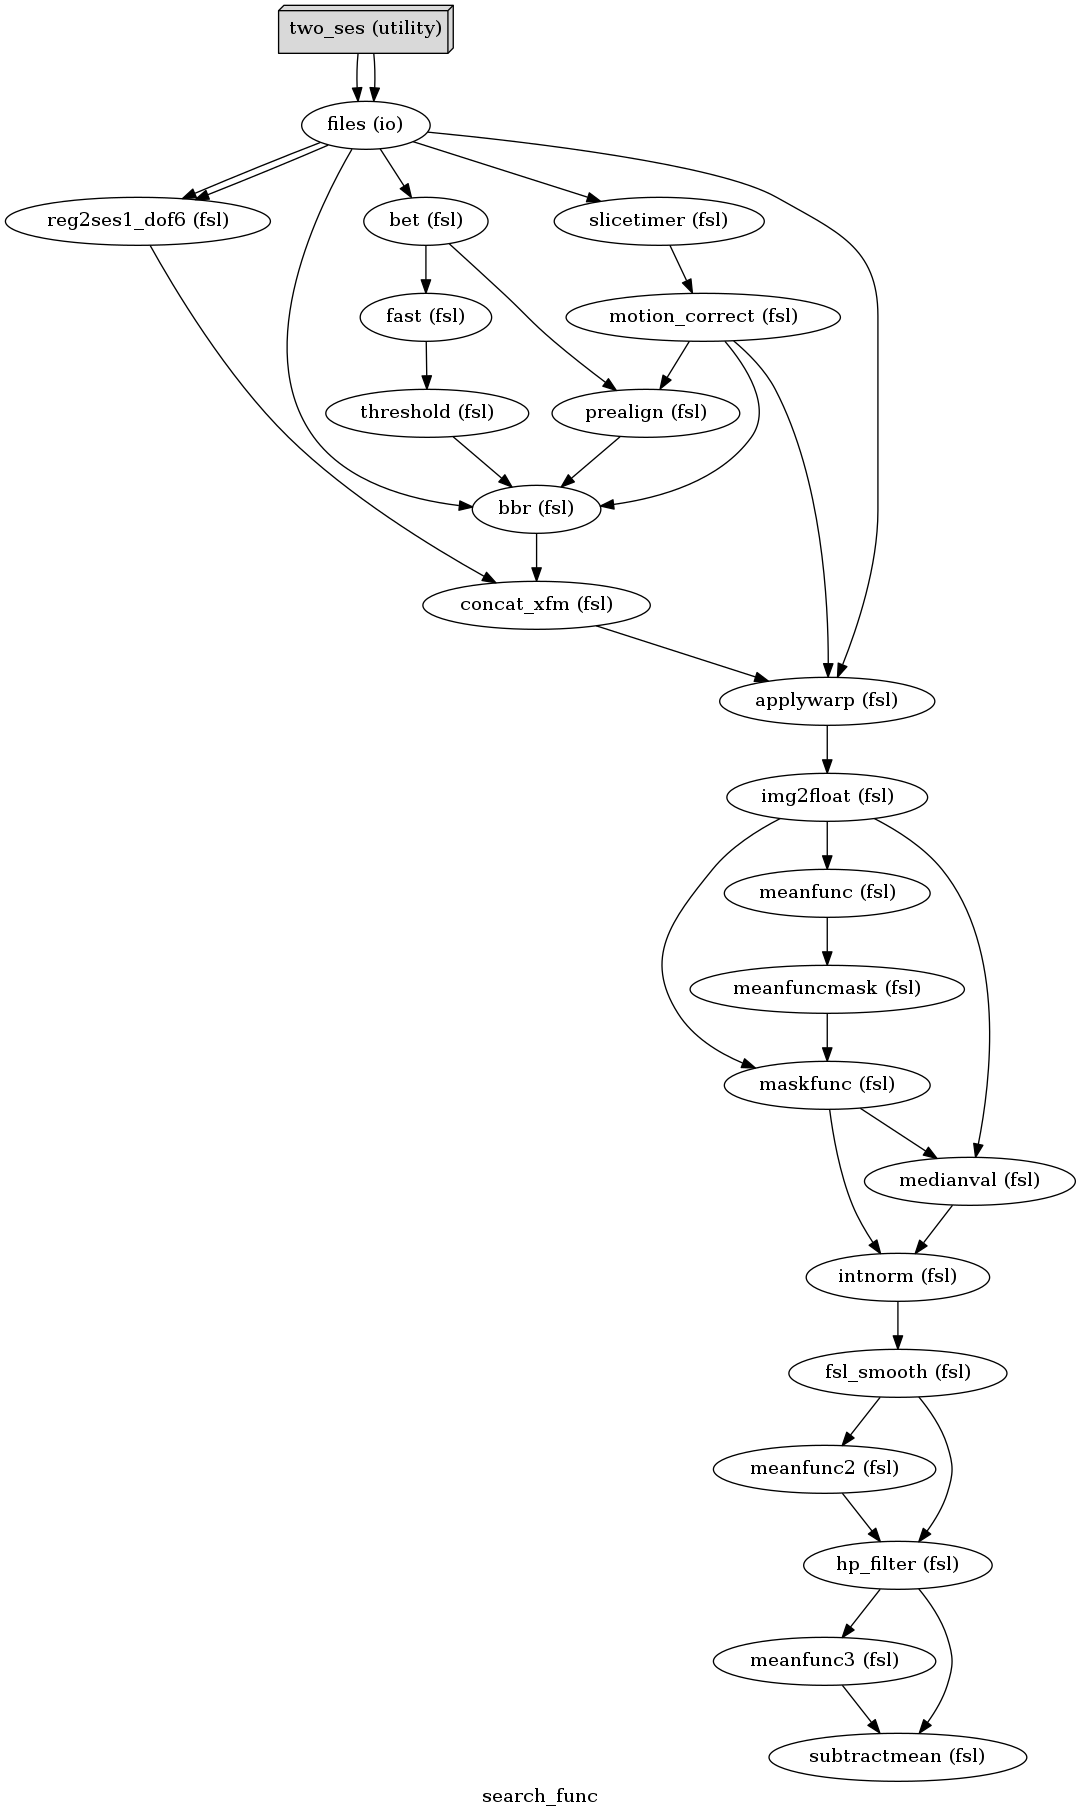

In [12]:
preprocessing.write_graph(simple_form=True, graph2use="hierarchical", dotfilename='./graph_hierarchical.dot')

# Visualize graph
Image(width=768, filename="graph_hierarchical.png")

# Localizer

Copy of the pipeline above, renamed with prefix `loc_` and adjusted to two sessions per subject and no subtract mean.  

In [13]:
loc_input = pe.Node(
    util.IdentityInterface(
        fields=["sub_id", "ses_id"]),
    name='loc_input')

# Session 1 and 2 for each subject
loc_input.iterables = [
    ("sub_id", ["sub_%03d" % i for i in range(1, 7)]),
    ("ses_id", ["ses_%03d" % i for i in range(2)])
]

# File templates for different subjects and sessions
templates = dict(
    loc_func='nii/{sub_id}/{ses_id}/localizer/run_*.nii.gz',
    inplane='nii/{sub_id}/{ses_id}/anatomy/inplane.nii.gz',
    inplane1='nii/{sub_id}/ses_000/anatomy/inplane.nii.gz',
)

# SelectFiles Node to handle 
# session specific file templates
loc_files = pe.Node(
    SelectFiles(
        templates, 
        base_directory=data_dir, 
        sort_filelist=True),
    name='loc_files')

# Slice time correction
loc_slicetimer = pe.MapNode(
    interface=fsl.SliceTimer(
        interleaved=True, 
        time_repetition=2.1),
    iterfield=["in_file"],
    name='loc_slicetimer'
)

# Motion Correction
loc_motion_correct = pe.MapNode(
    interface=fsl.MCFLIRT(
        cost='normmi',
        stages=4,
        interpolation='sinc',
        save_mats=True,
        save_plots=True,
        save_rms=True),
    iterfield=["in_file"],
    name='loc_motion_correct'
)

loc_bet = pe.Node(fsl.BET(frac=.15), name="loc_bet")

# Segment gray/white matter
loc_fast = pe.Node(fsl.FAST(out_basename='inplane_fast'), name='loc_fast')

# Apply binary threshold
loc_threshold = pe.Node(fsl.maths.Threshold(thresh=.5, args='-bin'), name='loc_threshold')

# Prealignment
loc_prealign = pe.MapNode(
    interface=fsl.FLIRT(dof=6), 
    iterfield=["in_file"],
    name='loc_prealign')

# Use boundary based registration
loc_bbr = pe.MapNode(
    interface=fsl.FLIRT(
        dof=6,
        cost='bbr',
        schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch'),
    iterfield=["in_file", "in_matrix_file"],
    name='loc_bbr'
)

# Concatenate transformation matrices.
loc_concat_xfm = pe.MapNode(
    interface=fsl.ConvertXFM(concat_xfm=True),
    iterfield=["in_file"],
    name='loc_concat_xfm'
)

# Reg2ses1
loc_reg2ses1 = pe.Node(
    fsl.FLIRT(dof=6),
    name="loc_reg2ses1_dof6"
)

# Apply warp
loc_applywarp = pe.MapNode(
    interface=fsl.ApplyWarp(
        interp='spline'),
    iterfield=["in_file", "premat"],
    name='loc_applywarp'
)

# Create mean from functionals
loc_meanfunc = pe.MapNode(
    interface=fsl.ImageMaths(
        op_string='-Tmean',
        suffix='_mean'),
    iterfield=['in_file'],
    name='loc_meanfunc')

# Create a mask from meanfunc
loc_meanfuncmask = pe.MapNode(
    interface=fsl.BET(
        mask=True,
        no_output=True,
        frac=0.05),
    iterfield=['in_file'],
    name='loc_meanfuncmask')

# Mask functionals
loc_maskfunc = pe.MapNode(
    interface=fsl.ImageMaths(
        suffix='_bet',
        op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='loc_maskfunc')

# Fsl smooth
loc_smooth = pe.MapNode(
    interface=fsl.maths.IsotropicSmooth(
        fwhm=5),
    iterfield=["in_file"],
    name="loc_fsl_smooth",
)

# Highpass (temp) functionals
loc_highpass = pe.MapNode(
    interface=fsl.utils.ImageMaths(
        suffix="_hpf"
    ),
    iterfield=['in_file'],
    name='loc_hp_filter',
    overwrite=True,
)

TR = 2.1
filter_cutoff = 60.0
loc_highpass.inputs.op_string = '-bptf %d -1 -add' % (filter_cutoff / 2*TR)

# Create mean from functionals
loc_meanfunc2 = pe.MapNode(
    interface=fsl.ImageMaths(
        op_string='-Tmean',
        suffix='_mean'),
    iterfield=['in_file'],
    name='loc_meanfunc2',
    overwrite=True,
)

# Subtract mean from functionals
loc_subtract_mean = pe.MapNode(
    interface=fsl.ImageMaths(
        op_string='-sub',
        suffix='_sub'),
    iterfield=['in_file', 'in_file2'],
    name='loc_subtract_mean',
    overwrite=True,
)

# Create pipeline
loc_prep = pe.Workflow(name='loc_func', base_dir=working_dir)

# Connect iterables to files: three conditions
loc_prep.connect(loc_input, 'sub_id', loc_files, 'sub_id')
loc_prep.connect(loc_input, 'ses_id', loc_files, 'ses_id')
loc_prep.connect(loc_files, 'loc_func', loc_slicetimer, 'in_file')
loc_prep.connect(loc_files, "inplane", loc_bet, "in_file")
loc_prep.connect(loc_files, 'inplane', loc_bbr, 'reference')
loc_prep.connect(loc_files, "inplane1", loc_reg2ses1, "reference")
loc_prep.connect(loc_files, "inplane", loc_reg2ses1, "in_file")
loc_prep.connect(loc_files, 'inplane1', loc_applywarp, 'ref_file')
loc_prep.connect(loc_slicetimer, 'slice_time_corrected_file', loc_motion_correct, 'in_file')
loc_prep.connect(loc_bet, "out_file", loc_fast, "in_files")
loc_prep.connect(loc_bet, "out_file", loc_prealign, "reference")
loc_prep.connect(loc_fast, ('partial_volume_files', select_last_in_list), loc_threshold, 'in_file')
loc_prep.connect(loc_motion_correct, 'out_file', loc_prealign, 'in_file')
loc_prep.connect(loc_prealign, "out_matrix_file", loc_bbr, "in_matrix_file")
loc_prep.connect(loc_threshold, 'out_file', loc_bbr, 'wm_seg')
loc_prep.connect(loc_motion_correct, 'out_file', loc_bbr, 'in_file')
loc_prep.connect(loc_bbr, "out_matrix_file", loc_concat_xfm, "in_file")
loc_prep.connect(loc_reg2ses1, 'out_matrix_file', loc_concat_xfm, 'in_file2')
loc_prep.connect(loc_concat_xfm, "out_file", loc_applywarp, "premat")
loc_prep.connect(loc_motion_correct, 'out_file', loc_applywarp, 'in_file')
loc_prep.connect(loc_applywarp, 'out_file', loc_meanfunc, 'in_file')
loc_prep.connect(loc_meanfunc, 'out_file', loc_meanfuncmask, 'in_file')
loc_prep.connect(loc_applywarp, 'out_file', loc_maskfunc, 'in_file')
loc_prep.connect(loc_meanfuncmask, 'mask_file', loc_maskfunc, 'in_file2')
loc_prep.connect(loc_maskfunc, 'out_file', loc_smooth, 'in_file')
loc_prep.connect(loc_smooth, 'out_file', loc_highpass, 'in_file')

180603-15:56:30,371 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


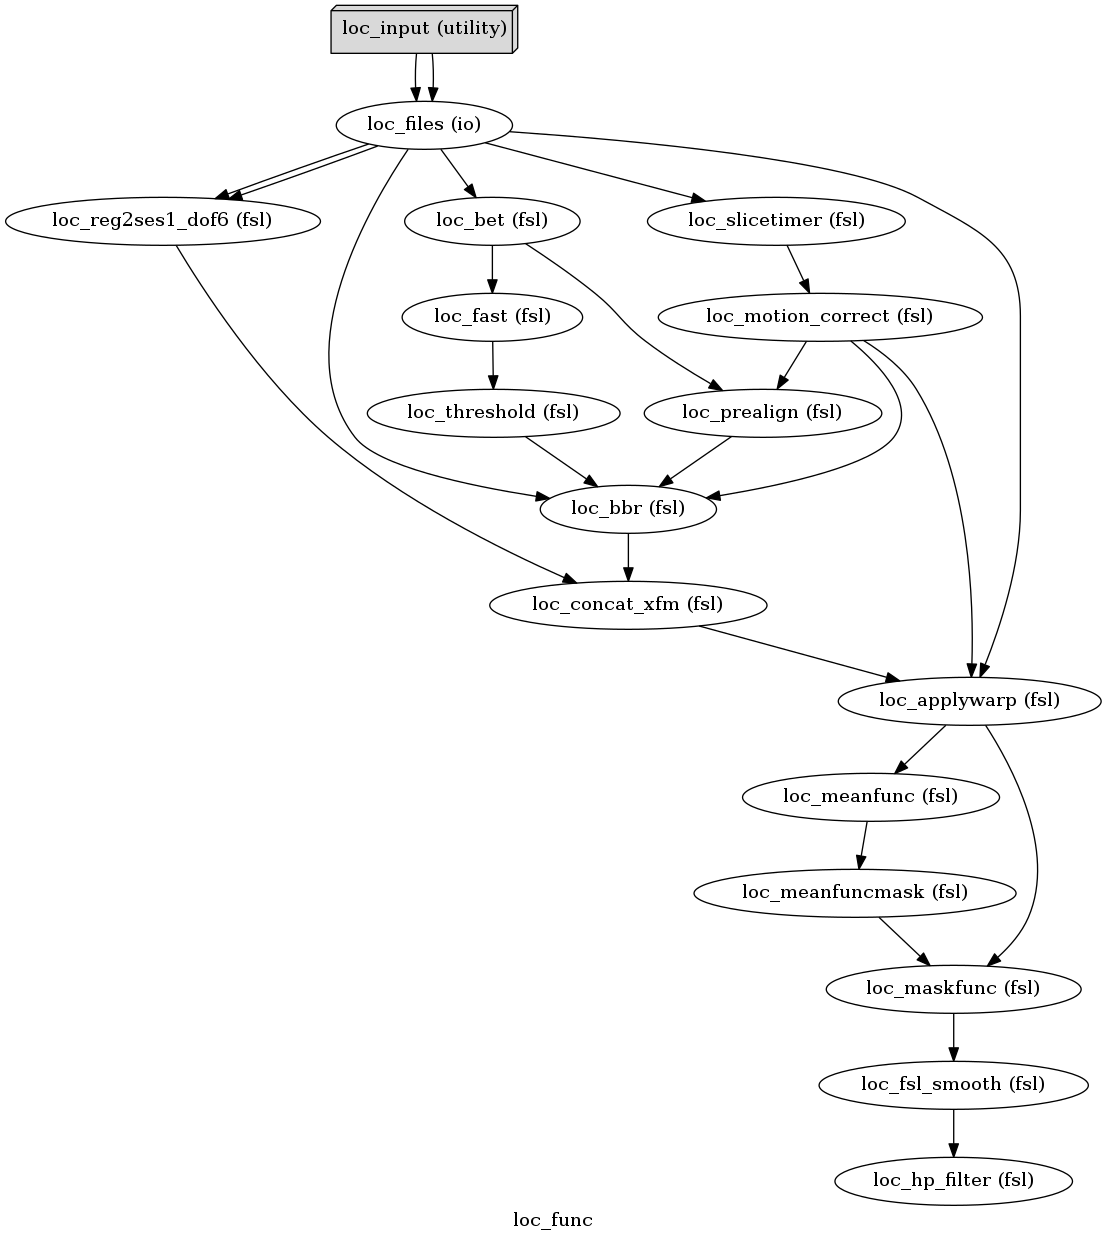

In [14]:
loc_prep.write_graph(simple_form=True, graph2use="hierarchical", dotfilename='./graph_hierarchical.dot')

# Visualize graph
Image(width=768, filename="graph_hierarchical.png")

# Registration

In [22]:
subs = pe.Node(
    util.IdentityInterface(
        fields=["sub_id"]),
    name='subs')

# Subjects with four sessions
subs.iterables = [
    ("sub_id", ["sub_%03d" % i for i in range(1, 7)]),
]

# File templates for different subjects and sessions
templates = {
    "inplane1" : 'nii/{sub_id}/ses_000/anatomy/inplane.nii.gz',
    "fs_orig"  : 'fs_subjects/{sub_id}/mri/orig.nii.gz',
    "fs_brain" : 'fs_subjects/{sub_id}/mri/brain.nii.gz',
}

# SelectFiles Node to handle 
# session specific file templates
reg_files = pe.Node(
    SelectFiles(
        templates, 
        base_directory=data_dir, 
        sort_filelist=True),
    name='reg_files')

reg_bet = pe.Node(
    fsl.BET(frac=.25),
    name="reg_bet")

# BbRegsiter Inplane 1 to hires
bbreg_inplane2hires = pe.Node(
    freesurfer.BBRegister(
        init="fsl",
        contrast_type="t1",
        subjects_dir=fs_dir,
        out_fsl_file=True
    ), 
    name='bbreg_inplane2hires'
)

# Hires to standard Flirt
flirt_hires2standard = pe.Node(
    fsl.FLIRT(
        reference=mni_standard_brain_path,        
    ), 
    name='flirt_hires2standard'
)

# Hires to standard FNirt
fnirt_hires2standard = pe.Node(
    fsl.FNIRT(
        fieldcoeff_file=True,
        field_file=True,
        ref_file=mni_standard_path,
        regularization_model="membrane_energy",
    ), 
    name='fnirt_hires2standard',
)

# Concatenate transformation matrices.
concat_xfm2 = pe.MapNode(
    interface=fsl.ConvertXFM(concat_xfm=True),
    iterfield=["in_file"],
    name='concat_xfm'
)

In [23]:
# Registration to fs hires and to MNI
registration = pe.Workflow(name='registration', base_dir=working_dir)
registration.connect(subs, 'sub_id', bbreg_inplane2hires, 'subject_id')
registration.connect(subs, 'sub_id', reg_files, 'sub_id')
registration.connect(reg_files, 'inplane1', reg_bet, 'in_file')
registration.connect(reg_bet, "out_file", bbreg_inplane2hires, "source_file")
registration.connect(reg_files, 'fs_brain', flirt_hires2standard, 'in_file')
registration.connect(reg_files, 'fs_orig', fnirt_hires2standard, 'in_file')
registration.connect(flirt_hires2standard, 'out_matrix_file', fnirt_hires2standard, 'affine_file')


180603-21:58:30,854 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


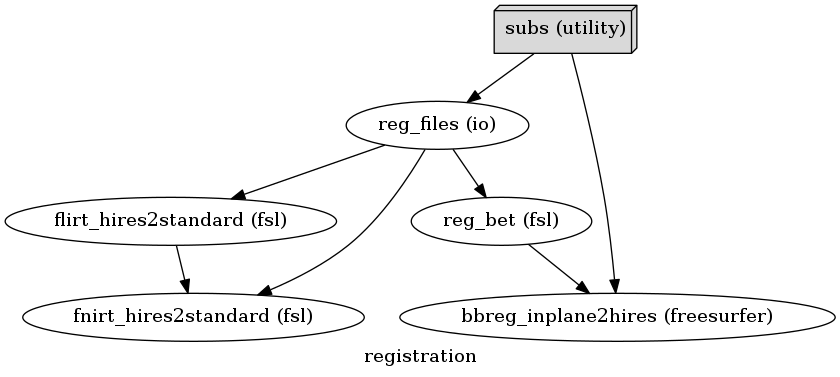

In [24]:
registration.write_graph(simple_form=True, graph2use="hierarchical", dotfilename='./graph_hierarchical.dot')

# Visualize graph
Image(width=768, filename="graph_hierarchical.png")

### Output nodes

In [25]:
# Create datasink to store important files in
# useful, more accessable locations.
datasink = pe.Node(
    DataSink(base_directory=base_dir,
             container="output"),
    name='datasink')

# Remove unwanted lengthy strings from filenames.
datasink.inputs.substitutions = [
    ('_sub_id_', ''),
    ('_ses_id_', '')
]

In [26]:
pipe = pe.Workflow(name='pipe', base_dir=working_dir)

# Outputs for search functionals
# pipe.connect(preprocessing, "applywarp.out_file", datasink, 'applywarp')
# pipe.connect(preprocessing, "reg2ses1_dof6.out_file", datasink, 'reg2ses1')
# pipe.connect(preprocessing, "reg2ses1_dof6.out_matrix_file", datasink, 'reg2ses1.@mat')
# pipe.connect(preprocessing, "fsl_smooth.out_file", datasink, 'smooth.@out_file')
# pipe.connect(preprocessing, "hp_filter.out_file", datasink, 'highpass.@out_file')
# pipe.connect(preprocessing, "subtractmean.out_file", datasink, 'subtractmean.@out_file')

# Outputs for localizer funcs
# pipe.connect(loc_prep, "loc_applywarp.out_file", datasink, 'loc_applywarp')
# pipe.connect(loc_prep, "loc_reg2ses1_dof6.out_file", datasink, 'loc_reg2ses1')
# pipe.connect(loc_prep, "loc_reg2ses1_dof6.out_matrix_file", datasink, 'loc_reg2ses1.@mat')
# pipe.connect(loc_prep, "loc_fsl_smooth.out_file", datasink, 'loc_smooth.@out_file')
# pipe.connect(loc_prep, "loc_hp_filter.out_file", datasink, 'loc_highpass.@out_file')

pipe.connect(registration, "fnirt_hires2standard.warped_file", datasink, 'register_to_standard.@warped_file')
pipe.connect(registration, "fnirt_hires2standard.field_file", datasink, 'register_to_standard.@field_file')
pipe.connect(registration, "fnirt_hires2standard.fieldcoeff_file", datasink, 'register_to_standard.@fieldcoeff_file')
pipe.connect(registration, "flirt_hires2standard.out_matrix_file", datasink, 'register_to_standard.@out_matrix_file')
pipe.connect(registration, "bbreg_inplane2hires.out_reg_file", datasink, 'register_to_standard.@out_reg_file')
pipe.connect(registration, "bbreg_inplane2hires.out_fsl_file", datasink, 'register_to_standard.@out_fsl_file')

180603-21:58:46,346 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


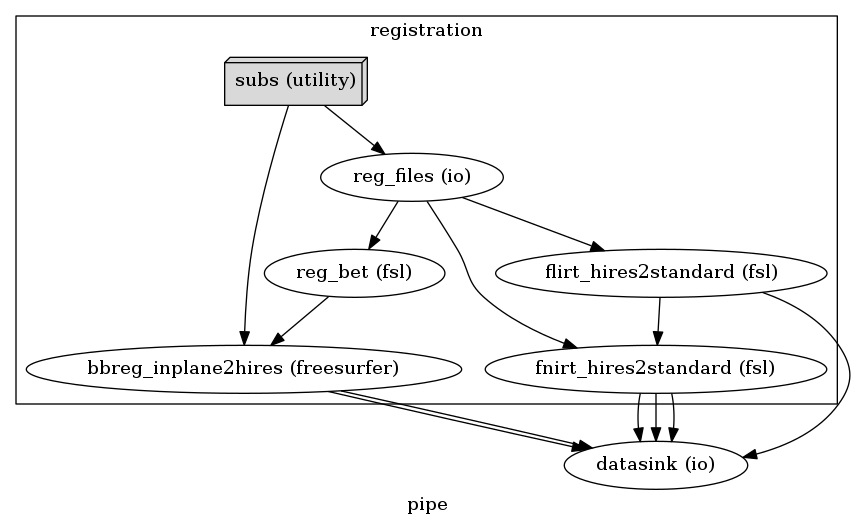

In [27]:
pipe.write_graph(simple_form=True, graph2use="hierarchical", dotfilename='./graph_hierarchical.dot')

# Visualize graph
Image(width=768, filename="graph_hierarchical.png")

In [ ]:
pipe.run(plugin='MultiProc', plugin_args={'n_procs': 4})